In [1]:
%matplotlib inline


## Gradients

Let's learn about gradients. We'll start with visualizing a vector in 2d space.


2024-11-28 15:01:39.248495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732834899.260890  173694 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732834899.264700  173694 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 15:01:39.277161: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1732834900.372537  173694 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 62

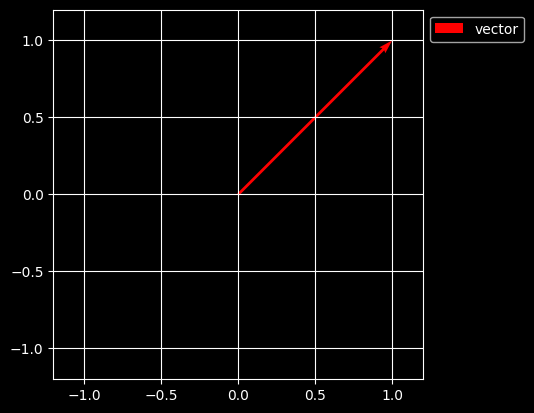

In [2]:
from dlib.helper import VectorScene
import tensorflow as tf

vector = tf.Variable([1.0,1.0])

scene = VectorScene()
(scene
 .add_vector(vector, color='r', name='vector')
 .display()
 )



Let's calculate it's length and angle:

In [3]:
length = tf.sqrt(tf.reduce_sum(vector*vector))
angle = tf.atan2(vector[1], vector[0])
print('The length of the vector is:', length.numpy())
print('The angle of the vector is:', angle.numpy())

The length of the vector is: 1.4142135
The angle of the vector is: 0.7853982


Let's now calculate angle and length, while recording this new concept called a gradient. 

In [4]:

with tf.GradientTape(persistent=True) as tape:
    length = tf.sqrt(tf.reduce_sum(vector*vector))
    angle = tf.atan2(vector[1], vector[0])
    
length_grad = tape.gradient(length, vector)
angle_grad = tape.gradient(angle, vector)
del tape


Now let's look at what these gradients do:

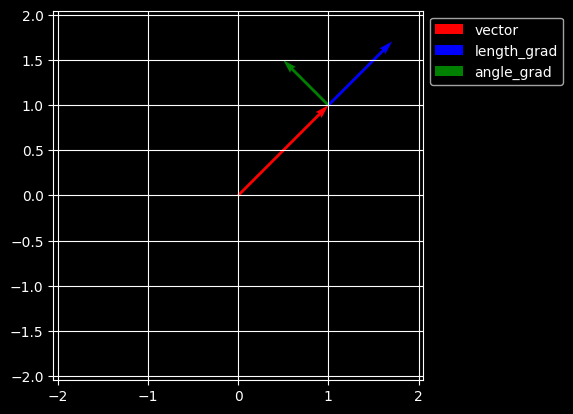

In [5]:
scene = VectorScene()
(scene
 .add_vector(vector, color='r', name='vector')
 .add_vector_at(vector, length_grad, color='b', name='length_grad')
 .add_vector_at(vector, angle_grad, color='g', name='angle_grad')
 .display()
 )


Ah ha! The `length_grad` points in the direction that the vector should move in to increase it's length. The angle vector points in the direction of an increase in angle. 

## Gradient Ascent

We expect if we add the gradient to our vector that we get a vector with a larger angle. Let's give that a spin.

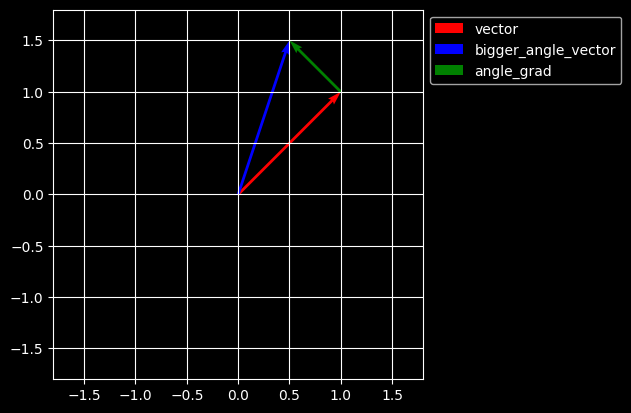

In [6]:
vector = tf.Variable([1.0,1.0])
with tf.GradientTape(persistent=True) as tape:
    angle = tf.atan2(vector[1], vector[0])

angle_grad = tape.gradient(angle, vector)

bigger_angle_vector = vector + angle_grad

(VectorScene()
 .add_vector(vector, color='r', name='vector')
 .add_vector(bigger_angle_vector, color='b', name='bigger_angle_vector')
 .add_vector_at(vector, angle_grad, color='g', name='angle_grad')
 .display())


As promised with get a vector with a bigger angle. 

**Looping**

What if we do this on repeat? We should get our vector to spin. We will have to replace the following line `bigger_angle_vector = vector + angle_grad` with `vector.assign_add(angle_grad)` since we don't want to create new tensorflow vectors. 

In [7]:
vector = tf.Variable([1.0,1.0])
vector_snaps = []
grad_snaps = []
for i in range(100):
    with tf.GradientTape(persistent=True) as tape:
        angle = tf.atan2(vector[1], vector[0])
    angle_grad = tape.gradient(angle, vector)
    del tape
    vector_snaps.append(vector.numpy().copy())
    grad_snaps.append(angle_grad.numpy().copy())
    vector.assign_add(angle_grad)

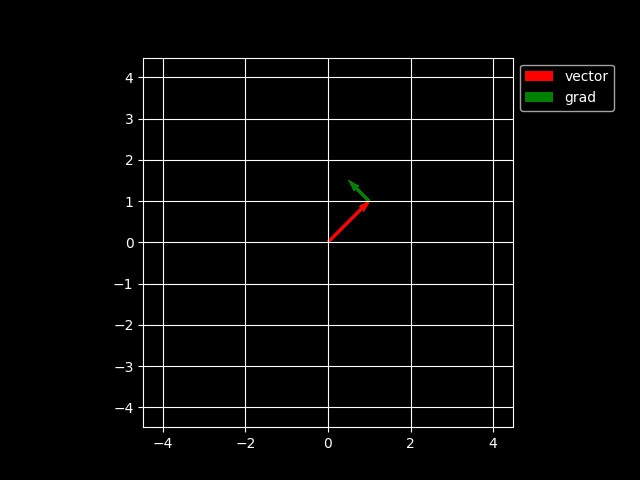

In [8]:
scene = VectorScene()
(scene
 .add_animated_vector(vector_snaps, color='r', name='vector')
 .add_animated_vector_at(vector_snaps, grad_snaps, color='g', name='grad')
 .animate()
 )

In the above we are maximizing the vector angle, let's now try maximizing the vector length:

In [9]:
vector = tf.Variable([1.0,1.0])
vector_snaps = []
grad_snaps = []
for i in range(100):
    with tf.GradientTape(persistent=True) as tape:
        length = tf.sqrt(tf.reduce_sum(vector*vector))
    length_grad = tape.gradient(length, vector)
    del tape
    vector_snaps.append(vector.numpy().copy())
    grad_snaps.append(length_grad.numpy().copy())
    vector.assign_add(length_grad)

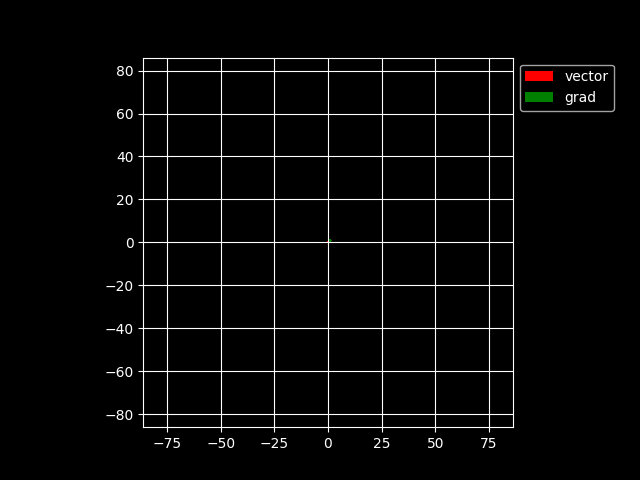

In [10]:
scene = VectorScene()
(scene
 .add_animated_vector(vector_snaps, color='r', name='vector')
 .add_animated_vector_at(vector_snaps, grad_snaps, color='g', name='grad')
 .animate()
 )

Minimizing should look be the same but with using `assign_sub`, instead of `assign_add`.

In [11]:
vector = tf.Variable([1.0,1.0])
vector_snaps = []
grad_snaps = []
for i in range(100):
    with tf.GradientTape(persistent=True) as tape:
        length = tf.sqrt(tf.reduce_sum(vector*vector))
    length_grad = tape.gradient(length, vector)
    del tape
    vector_snaps.append(vector.numpy().copy())
    grad_snaps.append(length_grad.numpy().copy())
    vector.assign_sub(length_grad)

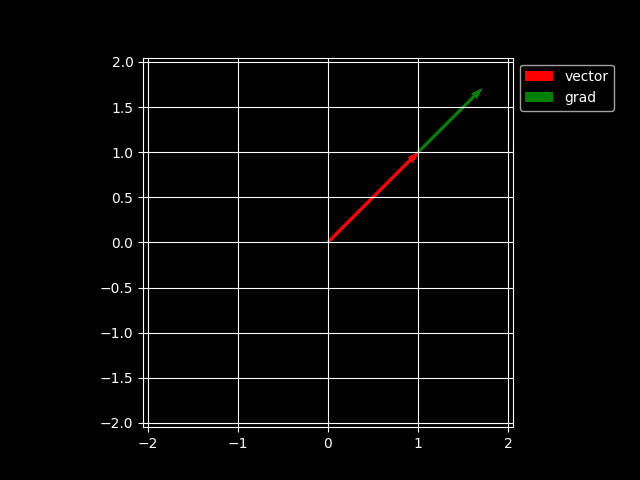

In [12]:
scene = VectorScene()
(scene
 .add_animated_vector(vector_snaps, color='r', name='vector')
 .add_animated_vector_at(vector_snaps, grad_snaps, color='g', name='grad')
 .animate()
 )

Hmm, that's not what we wanted. The vector is jumping *too far* in the correct direction, let's multiply the gradient by a small number to get rid of this behavior. This small constant is called a *learning rate*.

In [13]:
vector = tf.Variable([1.0,1.0])
vector_snaps = []
grad_snaps = []
leanring_rate = 0.1
for i in range(10):
    with tf.GradientTape(persistent=True) as tape:
        length = tf.sqrt(tf.reduce_sum(vector*vector))
    length_grad = tape.gradient(length, vector)
    del tape
    vector_snaps.append(vector.numpy().copy())
    grad_snaps.append(length_grad.numpy().copy())
    vector.assign_sub(leanring_rate*length_grad)

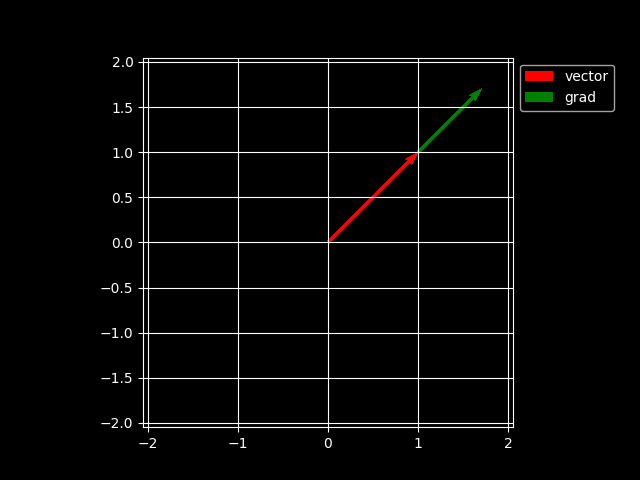

In [14]:
scene = VectorScene()
(scene
 .add_animated_vector(vector_snaps, color='r', name='vector')
 .add_animated_vector_at(vector_snaps, grad_snaps, color='g', name='grad')
 .animate()
 )

Perfect!

If we can minimize length, why can't we minimize a more complex function?

For example, maybe I want to find the middle point between two vectors, I could probably do that by minimizing the sum of the distance between the two of them.

In [15]:
vector = tf.Variable([1.0, 1.0])
vector_a = tf.constant([2.0, 4.0])
vector_b = tf.constant([3.0, 1.0])
vector_snaps = []
grad_snaps = []
learning_rate = 0.1
for i in range(50):
    with tf.GradientTape(persistent=True) as tape:
        one_near_blueberry = tf.reduce_sum((vector-vector_a)**2)
        one_near_strawberry = tf.reduce_sum((vector-vector_b)**2 )
        one_loss = one_near_blueberry + one_near_strawberry

    length_grad = tape.gradient(one_loss, vector)
    del tape
    vector_snaps.append(vector.numpy().copy())
    grad_snaps.append(length_grad.numpy().copy())
    vector.assign_sub(learning_rate*length_grad)

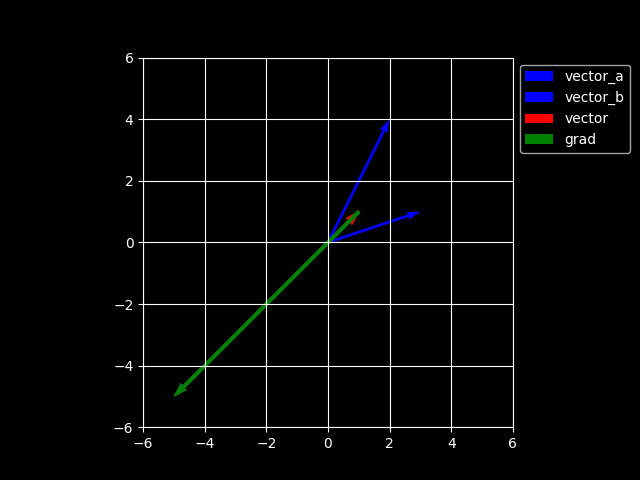

In [16]:
scene = VectorScene()
(scene
 .add_animated_vector(vector_snaps, color='r', name='vector')
 .add_animated_vector_at(vector_snaps, grad_snaps, color='g', name='grad')
 .add_vector(vector_a, color='b', name='vector_a')
 .add_vector(vector_b, color='b', name='vector_b')
 .animate()
 )

## Local Minima

Mr. Yellow *loves* strawberry ice cream but will settle for blueberry. His reward function shows him liking being near the blueberry, but values being near the stawberry twice as much.

We know gradients can help us maximize and minimize functions, in this case it can help Mr. Yellow get to his favorite ice cream.


In [32]:
vector_yellow = tf.Variable([1.0, 1.0])
vector_blueberry = tf.constant([2.0, 4.0])
vector_strawberry = tf.constant([3.0, 1.0])
yellow_snaps = []
gradient_snaps = []
learning_rate = 0.25


for i in range(50):
    with tf.GradientTape(persistent=True) as tape:
        yellow_near_blueberry = tf.reduce_sum((vector_yellow - vector_blueberry)**2)
        yellow_near_strawberry = tf.reduce_sum((vector_yellow - vector_strawberry)**2)
        yellow_loss = 1/(1 + yellow_near_blueberry) + 2/(1 + yellow_near_strawberry)

    length_yellow_grad = tape.gradient(yellow_loss, vector_yellow)
    del tape
    yellow_snaps.append(vector_yellow.numpy().copy())
    gradient_snaps.append(length_yellow_grad.numpy().copy())
    vector_yellow.assign_add(learning_rate * length_yellow_grad)



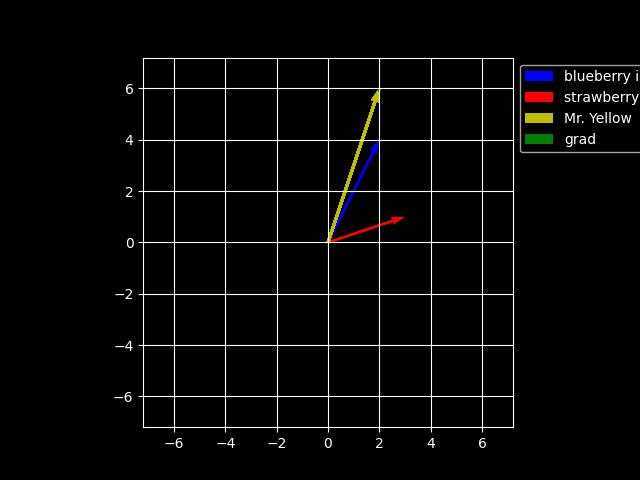

In [37]:
scene = VectorScene()
(scene
 .add_animated_vector(yellow_snaps, color='y', name='Mr. Yellow')
 .add_animated_vector_at(yellow_snaps, gradient_snaps, color='g', name='grad')
 .add_vector(vector_blueberry, color='b', name='blueberry ice cream')
 .add_vector(vector_strawberry, color='r', name='strawberry ice cream')
 .animate()
 )

Success! He got to it. 

But what if Mr. Yellow started closer the the blueberry, might he get distracted?

In [35]:
vector_yellow = tf.Variable([2.0, 6.0])
vector_blueberry = tf.constant([2.0, 4.0])
vector_strawberry = tf.constant([3.0, 1.0])
yellow_snaps = []
gradient_snaps = []
learning_rate = 0.25


for i in range(50):
    with tf.GradientTape(persistent=True) as tape:
        yellow_near_blueberry = tf.reduce_sum((vector_yellow - vector_blueberry)**2)
        yellow_near_strawberry = tf.reduce_sum((vector_yellow - vector_strawberry)**2)
        yellow_loss = 1/(1 + yellow_near_blueberry) + 2/(1 + yellow_near_strawberry)

    length_yellow_grad = tape.gradient(yellow_loss, vector_yellow)
    del tape
    yellow_snaps.append(vector_yellow.numpy().copy())
    gradient_snaps.append(length_yellow_grad.numpy().copy())
    vector_yellow.assign_add(learning_rate * length_yellow_grad)



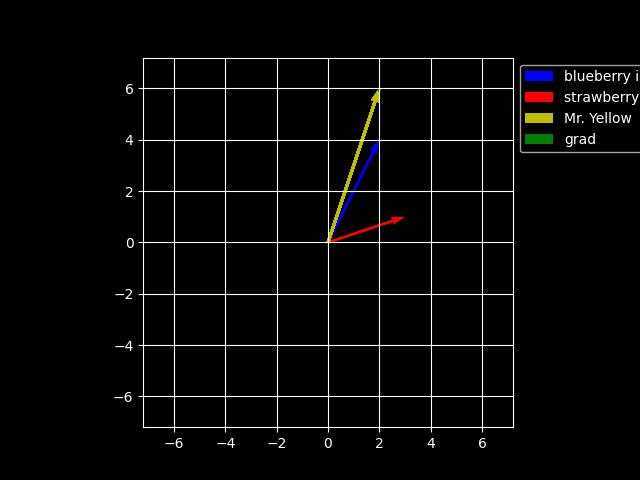

In [38]:
scene = VectorScene()
(scene
 .add_animated_vector(yellow_snaps, color='y', name='Mr. Yellow')
 .add_animated_vector_at(yellow_snaps, gradient_snaps, color='g', name='grad')
 .add_vector(vector_blueberry, color='b', name='blueberry ice cream')
 .add_vector(vector_strawberry, color='r', name='strawberry ice cream')
 .animate()
 )

Oh no! Mr. Yellow is now stuck with blueberry. Though he likes blueberry, we know he much prefers strawberry, what happened? 

As Mr. Yellow got closer to the blueberry, his gradient started disappearing. Look closely at the gradient vector, it gets smaller as it gets close to blueberry. 

This is the biggest problem with gradient descent (or ascent in this case) - it perfers *local minima*.

## Data

We've found something that can find the minima or maxima of pretty much any function. Well, kindof. The function needs to be *differentiable*, which means we can take gradients of it. Also - sometimes we don't get to the true minimum, but a local minima. 

Despite it's fault, this is an astonishingly powerful tool. Minimization and Maximization are everywhere you look. Economics maximizes utility, physics minimizes a lagrangian, but it also turns out that **predicting the future** can also be formulated in terms of minimization. Something that I hope gives you shivers the way it does for me. 



Armed with our very simply minimization tool, we are going to start doing some statistics. We're going to start very simple.

**Finding North**

Say we don't know which way north is. But when the wind